In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
# imports
import torch
from torchvision.datasets import CIFAR100
from torchvision import transforms
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from sklearn import svm, linear_model
import numpy as np
import matplotlib.pyplot as plt

from models import (
    OneUpOneDownAutoencoder,
    SimpleDecoderLayer,
    HierarchicalAutoencoder
)

from utils import imshow

In [4]:
dummy_input = torch.ones([4,3,224,224])
dummy_input.shape

torch.Size([4, 3, 224, 224])

In [7]:
model = OneUpOneDownAutoencoder(3, 16, padding = 1, stride = 2)
encoded, decoded = model(dummy_input)
dummy_input.shape, encoded.shape, decoded.shape

(torch.Size([4, 3, 224, 224]),
 torch.Size([4, 16, 112, 112]),
 torch.Size([4, 3, 224, 224]))

In [11]:
model = HierarchicalAutoencoder(OneUpOneDownAutoencoder, SimpleDecoderLayer, 3, 3, 
                                output_sizes=32, stride = 2, padding = 1)
model.load_state_dict(torch.load("initial_model_3layers.pth"))
encoded, decoded = model(dummy_input)
dummy_input.shape, encoded.shape, decoded.shape

(torch.Size([4, 3, 224, 224]),
 torch.Size([4, 128, 28, 28]),
 torch.Size([4, 3, 224, 224]))

In [9]:
summary(model.cuda(), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
              ReLU-2         [-1, 32, 112, 112]               0
   ConvTranspose2d-3          [-1, 3, 224, 224]             867
              ReLU-4          [-1, 3, 224, 224]               0
OneUpOneDownAutoencoder-5  [[-1, 32, 112, 112], [-1, 3, 224, 224]]               0
            Conv2d-6           [-1, 64, 56, 56]          18,496
              ReLU-7           [-1, 64, 56, 56]               0
   ConvTranspose2d-8         [-1, 32, 112, 112]          18,464
              ReLU-9         [-1, 32, 112, 112]               0
OneUpOneDownAutoencoder-10  [[-1, 64, 56, 56], [-1, 32, 112, 112]]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
             ReLU-12          [-1, 128, 28, 28]               0
  ConvTranspose2d-13           [-1, 64, 56, 56]          73,792
 

In [23]:
train_dataset = CIFAR100(
    '/data/standard_datasets/cifar100',
    download=True,
    train = True,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
test_dataset = CIFAR100(
    '/data/standard_datasets/cifar100',
    download=True,
    train = False,
    transform=transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)
print("Train dataset len {}, test dataset len {}".format(
    len(train_dataset), len(test_dataset)))

Files already downloaded and verified
Files already downloaded and verified
Train dataset len 50000, test dataset len 10000


In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)

In [19]:
# setup tensorboard
writer = SummaryWriter('runs/just_one_loss/cifar100')
writer.add_graph(model, dummy_input.cuda())

In [20]:
def train(model, dataloader, writer, 
          optimizer,
          criterion = nn.MSELoss(),
          num_epochs=100,
          batch_size = 64,
          log_loss_increment=100):
    running_loss = 0.0
    for epoch in range(num_epochs):
        for i,data in enumerate(dataloader):
            img, _ = data
            img = torch.autograd.Variable(img).cuda()
            # ===================forward=====================
            _,output = model(img)
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # tensorboard
            if i > 0 and i % log_loss_increment == 0:
                writer.add_scalar('training loss',
                    running_loss / log_loss_increment ,
                    epoch * len(dataloader) + i)
                running_loss = 0.0
        # ===================log========================

        print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data))

epoch [1/100], loss:0.3223
epoch [2/100], loss:0.6760
epoch [3/100], loss:0.6225
epoch [4/100], loss:0.4034
epoch [5/100], loss:0.5592
epoch [6/100], loss:0.4908
epoch [7/100], loss:0.4640
epoch [8/100], loss:0.5223
epoch [9/100], loss:0.4836
epoch [10/100], loss:0.3829
epoch [11/100], loss:0.3515
epoch [12/100], loss:0.6069
epoch [13/100], loss:0.5629
epoch [14/100], loss:0.4549
epoch [15/100], loss:0.6621
epoch [16/100], loss:0.4558
epoch [17/100], loss:0.4343
epoch [18/100], loss:0.5503
epoch [19/100], loss:0.7273
epoch [20/100], loss:0.3975
epoch [21/100], loss:0.8669
epoch [22/100], loss:0.3633
epoch [23/100], loss:0.2674
epoch [24/100], loss:0.4143
epoch [25/100], loss:0.5546
epoch [26/100], loss:0.6033
epoch [27/100], loss:0.6190
epoch [28/100], loss:0.6052
epoch [29/100], loss:0.4825
epoch [30/100], loss:0.6690
epoch [31/100], loss:0.5410
epoch [32/100], loss:0.7046
epoch [33/100], loss:0.3864
epoch [34/100], loss:0.5256
epoch [35/100], loss:0.4624
epoch [36/100], loss:0.3412
e

Let's show an example of the original and reconstructed image

Encoded shape torch.Size([1, 128, 28, 28]), decoded shape torch.Size([1, 3, 224, 224])


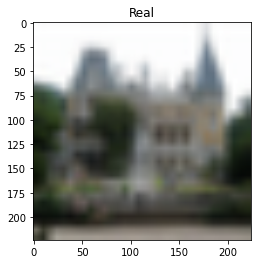

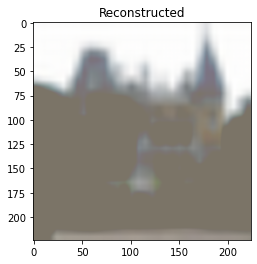

In [22]:
data, label = train_dataset[13]
data = data.unsqueeze(0)
encoded, decoded = model.cuda()(data.cuda())

data = data.detach().cpu()
encoded, decoded = encoded.detach().cpu(), decoded.detach().cpu()
print("Encoded shape {}, decoded shape {}".format(encoded.shape, decoded.shape))

imshow(data[0], "Real")
plt.pause(0.001)
imshow(decoded[0], "Reconstructed")

In [11]:
class ClassifierFromHierarchicalExtractor(nn.Module):
    """
    Given a feature extraction model, construct a classifier model with the
    given number of outputs by adding a linear layer as head

    :param extractor: A feature extraction model
    :param int feature_dimension: The output dimension of the feature
        vectors returned by the extractor
    :param int class_count: The number of output classes for the classifier
    """

    def __init__(self, extractor, class_count,
                layer_num=None,
                add_pooling = False):
        super(ClassifierFromHierarchicalExtractor, self).__init__()
        if layer_num is None:
            layer_num = len(extractor.encoder_layers)
            
        self.extractor = nn.ModuleList()
        for i in range(layer_num):
            self.extractor.append(extractor.encoder_layers[i].encoder)
            
        if add_pooling:
            self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        else:
            self.pool = None
            
        feature_dimension = extractor.encoder_layers[layer_num-1].out_channels
        self.classifier = nn.Linear(feature_dimension, class_count)

    def forward(self, x):
        for layer in self.extractor:
            x = layer(x)
            
        if self.pool is not None:
            x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
def train_and_eval_classifier_lr(hierarchical_model,
          train_dataset, test_dataset,
          batch_size = 64):
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
    
    number_of_layers = len(hierarchical_model.encoder_layers)
    for l in range(number_of_layers):
        feature_extractor = hierarchical_model.get_extractor(l)
        
        # freeze all layers 
        for name, param in feature_extractor.named_parameters():
            param.requires_grad = False
        
        feature_extractor = feature_extractor.cuda()
        feature_extractor.eval()
        
        all_output, all_target = None, None
        with torch.no_grad():
            for i,(images, target) in enumerate(train_dataloader):
                images = images.cuda(non_blocking=True)
                # ===================forward=====================
                output = feature_extractor(images)
                output = output.reshape(output.shape[0],-1).cpu()
                
                if all_output is None:
                    all_output = output
                else:
                    all_output = np.concatenate((all_output,output), axis = 0)
                    
                if all_target is None:
                    all_target = target
                else:
                    all_target = np.concatenate((all_target,target), axis = 0)
            
        classifier = linear_model.LogisticRegression(
            solver='lbfgs', random_state=0)
        
        print('Fitting Logistic Regression')
        classifier.fit(all_output, all_target)
            
        # now test
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        y_pred, y_actual = np.array([]), np.array([])
        with torch.no_grad():
            for i,(images, target) in enumerate(test_dataloader):
                images = images.cuda(non_blocking=True)
                # ===================accuracy=====================
                output = feature_extractor(images)
                output = output.reshape(output.shape[0],-1).cpu()
                preds_prob = classifier.predict_proba(output)
                preds = np.argmax(preds_prob, axis = 1)
                
                y_pred = np.concatenate((y_pred,preds.flatten()))
                y_actual = np.concatenate((y_actual,target.numpy().flatten()))
                    
        acc = np.sum(y_pred == y_actual)/y_pred.shape[0]
        print("{} - Accuracy: {:.4f}".format(l, acc))

In [140]:
def train_and_eval_classifier(feature_extractor, class_count,
          train_dataset, test_dataset,
          optimizer_func = torch.optim.SGD,
          learning_rate=30, # from Moco paper
          weight_decay=0.0,
          momentum=0.9,
          schedule=[60,80],
          criterion = nn.CrossEntropyLoss(),
          num_epochs=100,
          batch_size = 64):
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def adjust_learning_rate(optimizer, epoch, lr):
        """
        Decay the learning rate based on schedule
        (From MoCO)
        """
        for milestone in schedule:
            lr *= 0.1 if epoch >= milestone else 1.
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
    
    number_of_layers = len(feature_extractor.encoder_layers)
    for l in range(number_of_layers):
        classifier_model = ClassifierFromHierarchicalExtractor(feature_extractor, 
            layer_num = l+1,
            class_count=class_count, add_pooling=True)
        # freeze all layers but the last fc
        for name, param in classifier_model.named_parameters():
            if name not in ['classifier_model.weight', 'classifier.bias']:
                param.requires_grad = False
        # init the fc layer
        classifier_model.classifier.weight.data.normal_(mean=0.0, std=0.01)
        classifier_model.classifier.bias.data.zero_()
        
        
        classifier_model = classifier_model.cuda()
        classifier_model.eval()
        
        optimizer = optimizer_func(classifier_model.parameters(), 
                learning_rate, momentum, weight_decay)
        
        for epoch in range(num_epochs):
            adjust_learning_rate(optimizer, epoch, learning_rate)
            running_loss, num_samples = 0.0, 0
            for i,(images, target) in enumerate(train_dataloader):
                images = images.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
                # ===================forward=====================
                output = classifier_model(images)
                loss = criterion(output, target)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # log
                running_loss += loss.item()
                num_samples += images.shape[0]
            if epoch == (num_epochs - 1): # last epoch
                print('{} - epoch [{}/{}], loss:{:.4f}'.format(l,epoch+1, num_epochs, running_loss/num_samples))
            
        # now test
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        y_pred, y_actual = torch.Tensor(), torch.Tensor()
        with torch.no_grad():
            for i,(images, target) in enumerate(test_dataloader):
                images = images.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)
                # ===================accuracy=====================
                output = classifier_model(images)
                _, pred = output.topk(1, 1, True, True)
                y_pred = torch.cat((y_pred,pred.cpu().flatten()),0)
                y_actual = torch.cat((y_actual,target.cpu().flatten()),0)
        acc = torch.sum(y_pred == y_actual)/y_pred.shape[0]
        print("{} - Accuracy: {:.4f}".format(l, acc))

In [ ]:
train_and_eval_classifier_lr(model, 
          train_dataset, test_dataset, batch_size = 1024)

In [14]:
train_and_eval_classifier(model, 100,
          train_dataset, test_dataset, batch_size = 1024, num_epochs = 100)

0 - epoch [100/100], loss:0.0046
0 - Accuracy: 0.1024
1 - epoch [100/100], loss:0.0119
1 - Accuracy: 0.1122
2 - epoch [100/100], loss:0.0383
2 - Accuracy: 0.0916
